### Decision Tree - Label Classification

In [12]:
import sys
sys.path.append('../../../../')

# Import libraries
from utils.score import fold_cross_validate
from utils.print import print_cross_validation_scores
from constant.columns import FEATURES, LABEL, SIZE, TARGET_Y, MODE, IS_SINGLE_INPUT

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

#### Previous Version (v1) - use SMOTE in testing data

In [44]:
def resampling_data(X_test, y_test, desired_unhealthy_ratio, contain_print=True):
    # Ensure y_test is a Series
    if isinstance(y_test, pd.DataFrame):
        y_test = y_test.squeeze()  # Convert DataFrame with a single column to Series

    # Identify healthy and unhealthy indices
    healthy_indices = y_test[y_test == 0].index
    unhealthy_indices = y_test[y_test == 1].index

    # Print the number of healthy_indices and unhealthy_indices samples in the original dataset
    if contain_print:
        print('[Original] Number of healthy samples:', len(healthy_indices))
        print('[Original] Number of unhealthy samples:', len(unhealthy_indices))

    # Calculate the number of unhealthy samples to keep to achieve the desired ratio
    num_unhealthy_to_keep = int(len(healthy_indices) * desired_unhealthy_ratio / (1 - desired_unhealthy_ratio))

    # Shuffle the unhealthy indices to prevent bias
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(unhealthy_indices.to_numpy())

    # Keep only the first `num_unhealthy_to_keep` unhealthy indices
    indices_to_keep = unhealthy_indices[:num_unhealthy_to_keep]

    # Combine healthy indices with the selected unhealthy indices
    final_indices = healthy_indices.union(indices_to_keep)

    # Select rows from X_test and y_test based on the final indices
    new_X_test = X_test.loc[final_indices]
    new_y_test = y_test.loc[final_indices]

    # Print the number of healthy and unhealthy samples in the new dataset
    if contain_print:
        print('[Updated] Number of healthy samples:', len(new_y_test[new_y_test == 0]))
        print('[Updated] Number of unhealthy samples:', len(new_y_test[new_y_test == 1]))

    return new_X_test, new_y_test

In [9]:
IS_USE_PREVIOUS = True

# Import data
feat = FEATURES
if IS_SINGLE_INPUT ==  False:
    WINDOW_SIZE = f"{SIZE}_{TARGET_Y}"
    if MODE == 1:
        WINDOW_SIZE = f"{SIZE}_{TARGET_Y}_normalize"
    if MODE == 2:
        WINDOW_SIZE = f"{SIZE}_{TARGET_Y}_normalize_std"

    print(f'WINDOW_SIZE: {WINDOW_SIZE}')
    # Get features with window size
    expanded_features = []
    for feature in FEATURES:
        for i in range(SIZE):
            expanded_features.append(f'{feature}_{i}')
    
    feat = expanded_features

if IS_USE_PREVIOUS:
    # Read dataset
    df = pd.read_csv(f'./source/dataset_smote.csv')
    X, y = df[feat], df[LABEL]

    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    # Print the number of class healthy and unhealthy in the original data
    print("Before:", y_test.value_counts())

    # Resampling data
    X_test, y_test = resampling_data(X_test, y_test, 0.2)

    # Print the number of class healthy and unhealthy in the resampled data
    print("After:", y_test.value_counts())

    # Define the model
    clf_cv = DecisionTreeClassifier()
    scores = fold_cross_validate(clf_cv, X_test, y_test)

    # Print scores
    print_cross_validation_scores(scores)

WINDOW_SIZE: 10_10
Before: status
1         2651
0         2591
Name: count, dtype: int64
[Original] Number of healthy samples: 2591
[Original] Number of unhealthy samples: 2651
[Updated] Number of healthy samples: 2591
[Updated] Number of unhealthy samples: 647
After: status
0    2591
1     647
Name: count, dtype: int64
MACRO:
Precision: 0.6173 (0.0661)
Recall: 0.7741 (0.1758)
F1 score: 0.6364 (0.1045)
---------------------------------
MICRO:
Precision: 0.8637 (0.1051)
Recall: 0.8637 (0.1051)
F1 score: 0.8637 (0.1051)
---------------------------------


#### Newer Version (v2) - didn't use SMOTE in testing data

In [96]:
# # Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 1000), ('max_features', None), ('max_leaf_nodes', 2000), ('min_impurity_decrease', 0), ('min_samples_leaf', 1), ('min_samples_split', 2)])
# # Best score: 0.912223777807814

# # Import data
# feat = FEATURES
# if IS_SINGLE_INPUT ==  False:
#     WINDOW_SIZE = f"{SIZE}_{TARGET_Y}"
#     if MODE == 1:
#         WINDOW_SIZE = f"{SIZE}_{TARGET_Y}_normalize"
#     if MODE == 2:
#         WINDOW_SIZE = f"{SIZE}_{TARGET_Y}_normalize_std"

#     print(f'WINDOW_SIZE: {WINDOW_SIZE}')
#     # Get features with window size
#     expanded_features = []
#     for feature in FEATURES:
#         for i in range(SIZE):
#             expanded_features.append(f'{feature}_{i}')
    
#     feat = expanded_features

# # Read dataset
# df = pd.read_csv(f'./source/dataset_smote.csv')
# X_train, y_train = df[feat], df[LABEL]

# # Read test dataset
# df_test = pd.read_csv(f'./source/dataset_test.csv')
# X_test, y_test = df_test[feat], df_test[LABEL]

#### Test with Actual Data

In [97]:
from sklearn.metrics import f1_score

clf_cv = DecisionTreeClassifier()

# Train the model with SMOTE data
clf_cv.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = clf_cv.predict(X_test)

# Calculate the macro-averaged F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print the macro-averaged F1 score
print(f"Macro-averaged F1 score: {f1_macro}")

Macro-averaged F1 score: 0.8449313586937948


### Hyperparameter Tuning

In [98]:
# Best parameters: OrderedDict([('criterion', 'entropy'), ('max_depth', 166), ('max_features', None), ('max_leaf_nodes', 687), ('min_impurity_decrease', 0), ('min_samples_leaf', 1), ('min_samples_split', 2)])
# Best score: 0.898899854454981

# Best parameters: OrderedDict([('criterion', 'gini'), ('max_depth', 1000), ('max_features', None), ('max_leaf_nodes', 2000), ('min_impurity_decrease', 0), ('min_samples_leaf', 1), ('min_samples_split', 2)])
# Best score: 0.912223777807814


clf_cv = DecisionTreeClassifier(
    criterion='gini',
    max_depth=1000,
    max_features=None,
    max_leaf_nodes=2000,
    min_impurity_decrease=0,
    min_samples_leaf=1,
    min_samples_split=2
)
clf_cv.fit(X_train, y_train)

# Use the trained model to make predictions on the test set
y_pred = clf_cv.predict(X_test)

# Calculate the macro-averaged F1 score
f1_macro = f1_score(y_test, y_pred, average='macro')

# Print the macro-averaged F1 score
print(f"Macro-averaged F1 score: {f1_macro}")

Macro-averaged F1 score: 0.8394692543667627


### Confusion Matrix

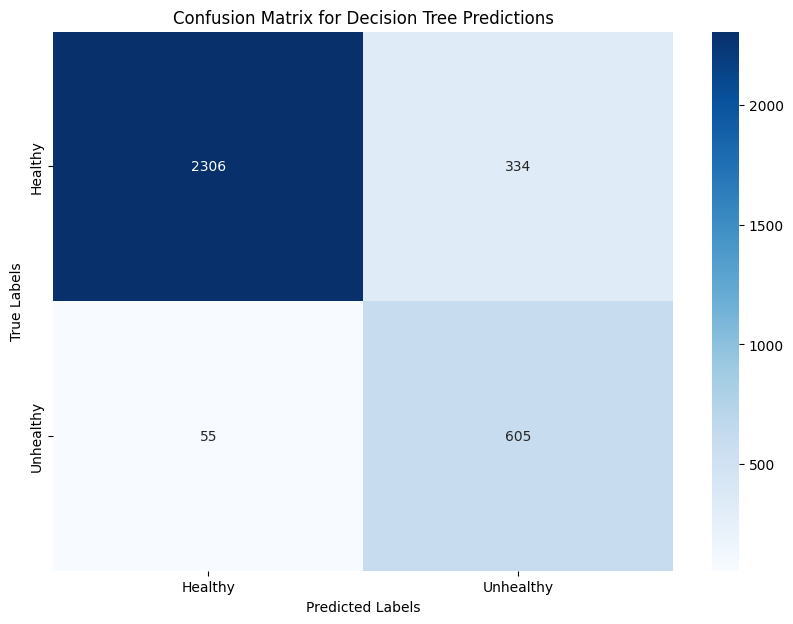

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Seaborn for better visualization

# Assuming y_test and y_pred are available from your previous code
# y_test: true labels
# y_pred: predictions from the Decision Tree model

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

unique_labels = ["Healthy", "Unhealthy"]

# Plot using seaborn for a more appealing matrix visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Decision Tree Predictions')
plt.show()

### Averaged Confusion Matrix with KFold

In [46]:
def plot_averaged_confusion_matrix_with_kfold(model, X, y, n_splits=5, resampling_size=0.2):
    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=n_splits)

    # Initialize the list to store the confusion matrices
    cms = []

    # Initialize the f1 (macros) scores
    f1_scores = []

    # Loop through each fold
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Resample the test set
        X_test, y_test = resampling_data(X_test, y_test, resampling_size, contain_print=False)

        # Train the model
        model.fit(X_train, y_train)

        # Use the trained model to make predictions on the test set
        y_pred = model.predict(X_test)

        # Compute the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        cms.append(cm)

        # Find the f1 score (macro)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_scores.append(f1_macro)

    # Print all f1 scores and confusion matrices
    print('f1_scores:', f1_scores)
    print('cms:', cms)
    
    # Calculate the average confusion matrix
    avg_cm = np.mean(cms, axis=0)

    # Print the average RMSE score
    print(f'Average f1_score: {np.mean(f1_scores)}')

    unique_labels = ["Healthy", "Unhealthy"]

    # Plot using seaborn for a more appealing matrix visualization
    plt.figure(figsize=(10, 7))
    sns.heatmap(avg_cm, annot=True, fmt='g', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Averaged Confusion Matrix for Decision Tree Predictions')
    plt.show()


f1_scores: [0.9206014842661308, 0.8309389111294891, 0.861383649695955, 0.9118457442284247, 0.9043885991254412, 0.9236810594726639, 0.8840192948711492, 0.87191147376968, 0.8403709722938584, 0.8046431518891959]
cms: [array([[502,  23],
       [ 19, 156]], dtype=int64), array([[442,  83],
       [ 16, 159]], dtype=int64), array([[459,  65],
       [ 14, 160]], dtype=int64), array([[482,  42],
       [  7, 167]], dtype=int64), array([[487,  37],
       [ 15, 159]], dtype=int64), array([[496,  28],
       [ 13, 161]], dtype=int64), array([[466,  58],
       [  8, 166]], dtype=int64), array([[462,  62],
       [ 11, 163]], dtype=int64), array([[440,  84],
       [ 10, 164]], dtype=int64), array([[422, 102],
       [ 15, 159]], dtype=int64)]
Average f1_score: 0.8753784340741987


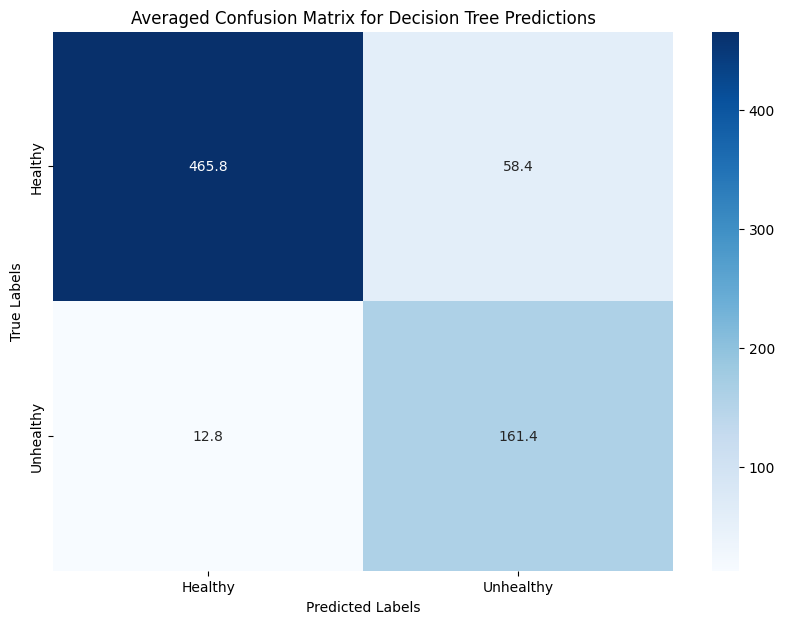

In [57]:
X_avg_confusion, y_avg_confusion = df[feat], df[LABEL]
# X_avg_confusion, y_avg_confusion = resampling_data(X_avg_confusion, y_avg_confusion, 0.24)
clf_cv = DecisionTreeClassifier(
    criterion='gini',
    max_depth=129,
    max_features=None,
    max_leaf_nodes=637,
    min_impurity_decrease=0,
    min_samples_leaf=1,
    min_samples_split=2
)

plot_averaged_confusion_matrix_with_kfold(clf_cv, X_avg_confusion, y_avg_confusion, n_splits=10, resampling_size=0.25)

### Find Best Parameters

In [102]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from sklearn.tree import DecisionTreeClassifier

# Define the hyperparameter space
search_space = {
    'max_depth': Integer(3, 1000),  # Depth of the tree
    'min_samples_split': Integer(2, 300),  # Minimum number of samples required to split a node
    'min_samples_leaf': Integer(1, 300),  # Minimum number of samples required at a leaf node
    'criterion': Categorical(['gini', 'entropy']),  # Function to measure the quality of a split
    'max_features': Categorical(['auto', 'sqrt', 'log2', None]),  # Number of features to consider for best split
    'max_leaf_nodes': Integer(10, 2000, prior='uniform'),  # Maximum number of leaf nodes
    'min_impurity_decrease': Integer(0, 10, prior='uniform'),  # Minimum impurity decrease required for a split to happen
}

# Create a DecisionTreeClassifier instance
dt = DecisionTreeClassifier()

# Set up the BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=dt,
    search_spaces=search_space,
    n_iter=500,  # Number of iterations
    scoring='f1_macro',  # Use F1 macro score
    n_jobs=-1,  # Use all CPU cores
    cv=10,       # 10-fold cross-validation
)

# Perform the search
bayes_search.fit(X_train, y_train)

# Best parameters and score
best_params = bayes_search.best_params_
best_score = bayes_search.best_score_

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best score:", best_score)

c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 